<a href="https://colab.research.google.com/github/francescagiacco/feminicides-italy/blob/main/scripts/05_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FINE TUNING THE PRE-TRAINED MODEL**

In this script I fine tune this [model](https://huggingface.co/responsibility-framing/predict-perception-bert-blame-victim) on my data 


---



In [ ]:
!pip install transformers==4.28.0
#!pip install news-please 
!pip install transformers_interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load packages
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines.text_classification import ClassificationFunction
from transformers_interpret import SequenceClassificationExplainer
import torch
from torch import tensor
from torch.nn import Sigmoid, Softmax
import tensorflow as tf
import torch
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datac=pd.read_csv("/content/drive/MyDrive/thesis/labeltest.csv")

<ipython-input-5-a9a5458c4404>:1: DtypeWarning: Columns (14,27,48) have mixed types. Specify dtype option on import or set low_memory=False.
  datac=pd.read_csv("/content/drive/MyDrive/thesis/labeltest.csv")


**Data preprocessing**

In [ ]:
 
data_ft= datac.dropna(subset=['sentence', 'vb_manual']).copy()
data_ft["vb_bin"]= data_ft['vb_manual'].apply(lambda x: 0 if x <4  else 1 )
data_ft["vb_class"]=data_ft['vb_manual'].apply(lambda x: 0 if x <5  else 1 if x<10 else 2 )

min_col = data_ft["vb_manual"].min()
max_col = data_ft["vb_manual"].max()
data_ft.loc[:, "vb_manual_norm"] = (data_ft["vb_manual"] - min_col) / (max_col - min_col)

max_col = data_ft["vb_manual_norm"].max()
print(max_col)
len(data_ft)

1.0


2682

<Axes: >

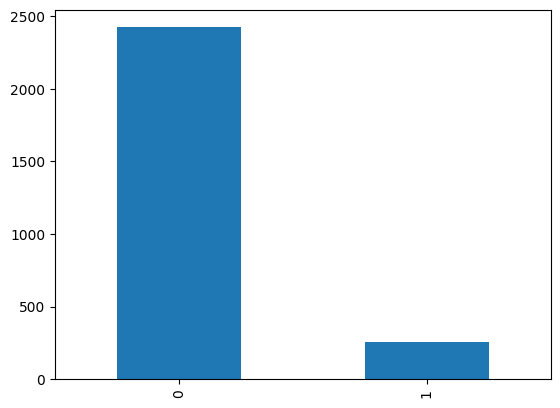

In [ ]:
counts = data_ft["vb_bin"].value_counts()
counts.plot(kind="bar")

**Prepare for training**

In [ ]:
X=list(data_ft['sentence'])
y=list(data_ft['vb_bin'])

In [ ]:
#train, validation, test split
from sklearn.model_selection import train_test_split
#training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=0)

#validation and test sets are 5% of the data each
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)



In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("responsibility-framing/predict-perception-bert-blame-assassin",
                                                           num_labels=2, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained("responsibility-framing/predict-perception-bert-blame-assassin")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at responsibility-framing/predict-perception-bert-blame-assassin and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
encoded_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
encoded_test = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
encoded_test_fin = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt")

In [ ]:
import torch

class ThesisDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ThesisDataset(encoded_train, y_train)
val_dataset = ThesisDataset(encoded_test, y_test)
test_dataset=ThesisDataset(encoded_test_fin, y_val)

In [ ]:
#change loss type
model.config.problem_type = 'single_label_classification'

In [ ]:
pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-_06cxvto
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-_06cxvto
  Resolved https://github.com/huggingface/accelerate to commit dcde1e93d09abea02a8e7f4a07a2c5734b87b60e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {'f1': f1}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset     
        #evaluation dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-13-6a7b81468718>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.307000,0.386180
2,0.124600,0.282686


TrainOutput(global_step=270, training_loss=0.2852114227082994, metrics={'train_runtime': 148.806, 'train_samples_per_second': 28.829, 'train_steps_per_second': 1.814, 'total_flos': 438711990373800.0, 'train_loss': 0.2852114227082994, 'epoch': 2.0})

In [ ]:
trainer.evaluate(test_dataset)

<ipython-input-13-6a7b81468718>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.23109689354896545,
 'eval_runtime': 1.7164,
 'eval_samples_per_second': 156.144,
 'eval_steps_per_second': 2.913,
 'epoch': 2.0}

In [ ]:
output=trainer.predict(val_dataset)[1]

<ipython-input-13-6a7b81468718>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,output)
cm

array([[238,   0],
       [  0,  31]])

In [ ]:
trainer.save_model('finetuned_model')